In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats

import os, sys

project_root = '/user_data/mmhender/featsynth/'
sys.path.insert(0, os.path.join(project_root, 'code'))
from utils import stats_utils, plot_utils

import get_gram_matrix_distances


In [2]:
# load image info
image_set_name = 'images_ecoset64'
image_list_filename = os.path.join(project_root, 'features','raw', '%s_list.csv'%(image_set_name))
labels = pd.read_csv(image_list_filename)

# figure out some image/category properties here
n_ims_each = np.sum(np.array(labels['basic_name'])==np.array(labels['basic_name'])[0])
basic_names = np.array(labels['basic_name'][0::n_ims_each])
super_names_long = np.array(labels['super_name'][0::n_ims_each])

n_basic = len(basic_names)
n_super = len(np.unique(super_names_long))
n_basic_each_super  = int(n_basic/n_super)
super_names = super_names_long[0::n_basic_each_super]
super_inds_long = np.repeat(np.arange(n_super), n_basic_each_super)

# more image properties to organize images
image_type_names = ['orig']
n_image_types = len(image_type_names)
cue_level_names = ['basic','super']

In [6]:
image_list_filename

'/user_data/mmhender/featsynth/features/raw/images_ecoset64_list.csv'

In [3]:
ecoset_info_path = '/user_data/mmhender/stimuli/ecoset_info/'
fn = os.path.join(ecoset_info_path, 'categ_use_ecoset.npy')
info = np.load(fn, allow_pickle=True).item()

#### get all the cosine distances

In [4]:
layer_names = ['pool1','pool2','pool3','pool4']
# layer_names = ['pool1','pool2', 'pool3']
n_layers = len(layer_names)

n_ims_vals =np.arange(8, 500, 8)
n_v = len(n_ims_vals)

fn = os.path.join(project_root, 'features', 'gram_matrices', 'distances', \
                  'cosine_distances_%s.npy'%image_set_name)
d = np.load(fn, allow_pickle=True).item()

within_b = d['within_b']
across_b_within_s = d['across_b_within_s']
across_b_all = d['across_b_all']
within_s = d['within_s']
across_s = d['across_s']

In [5]:
fn

'/user_data/mmhender/featsynth/features/gram_matrices/distances/cosine_distances_images_ecoset64.npy'

#### get ratio of across to within

In [8]:
basic_sep = across_b_within_s / within_b 
basic_sep_all = across_b_all / within_b 
super_sep_each_supcat = across_s / within_s

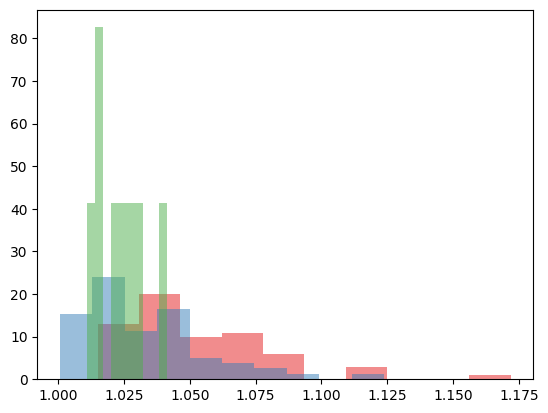

In [9]:
li = 0;
ni = 11;

cue_level_colors = cm.Set1(np.linspace(0,1,9))[0:3,:]

plt.figure()

for vi, vals in enumerate([basic_sep_all[:,li,ni], \
                         basic_sep[:,li,ni], \
                         super_sep_each_supcat[:,li,ni]]):
    
    plt.hist(vals, alpha=0.5, color=cue_level_colors[vi,:], density=True)

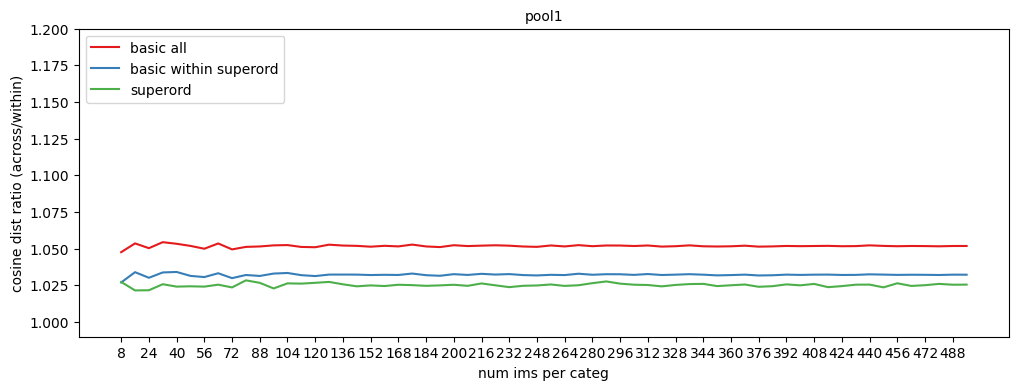

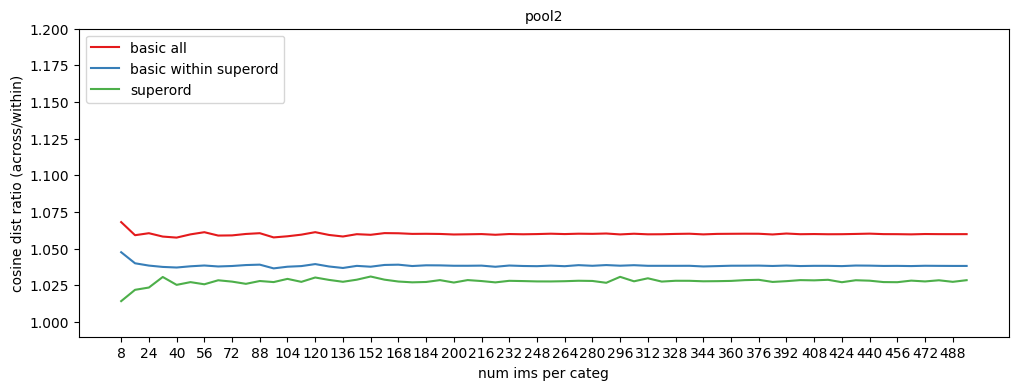

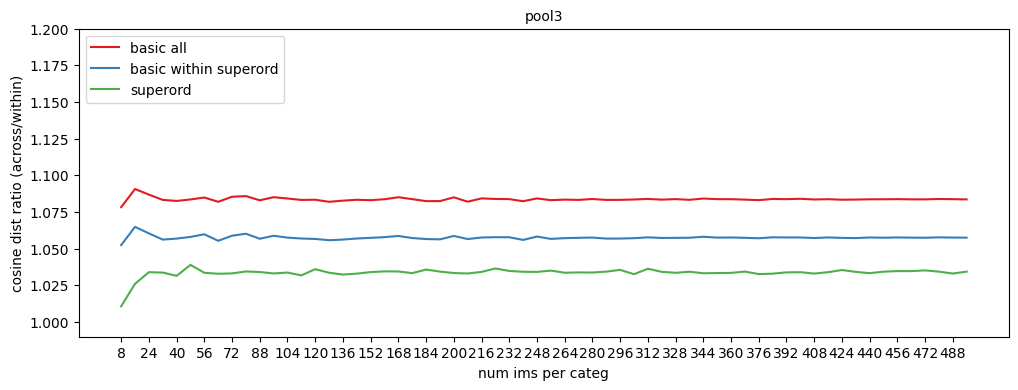

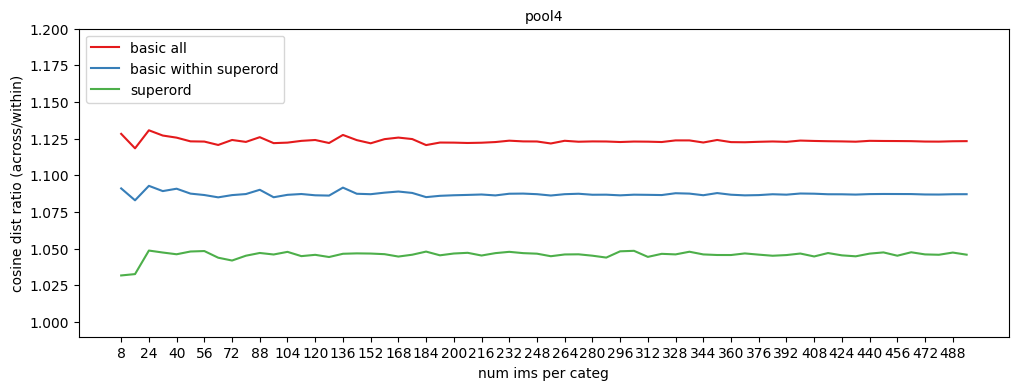

In [10]:
for li in range(n_layers):

    plot_utils.set_all_font_sizes(10)

    cue_level_colors = cm.Set1(np.linspace(0,1,9))[0:3,:]

    plt.figure(figsize=(12,4))

    ax = plt.subplot(1,1,1)
        # lh = []

    vals1 = np.mean(basic_sep_all[:,li,:], axis=0)
    vals2 = np.mean(basic_sep[:,li,:], axis=0)
    vals3 = np.mean(super_sep_each_supcat[:,li,:], axis=0)
    levels = ['basic all','basic within superord','superord']

    for cc, vals in enumerate([vals1, vals2, vals3]):
    # for cc, vals in enumerate([vals1,  vals3]):

        h = plt.plot(np.arange(n_v), vals,\
                 '-',color=cue_level_colors[cc,:])

        # lh.append(h[0])

    tick_inds_plot = np.arange(0, n_v, 2)
    plt.xticks(tick_inds_plot, n_ims_vals[tick_inds_plot], rotation=0)

        
    plt.xlabel('num ims per categ')

    # plt.axhline(0, color=[0.8, 0.8, 0.8], linestyle='--')

    # ax.legend(lh, np.repeat(cue_level_vals,2), loc='lower right')
    ax.legend(levels, loc='upper left')

    plt.ylabel('cosine dist ratio (across/within)')

    plt.title('%s'%layer_names[li])
    plt.ylim([0.99, 1.20])



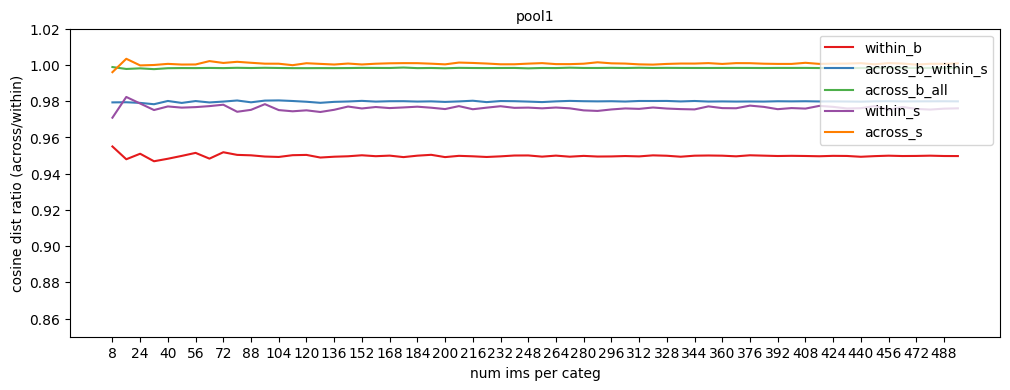

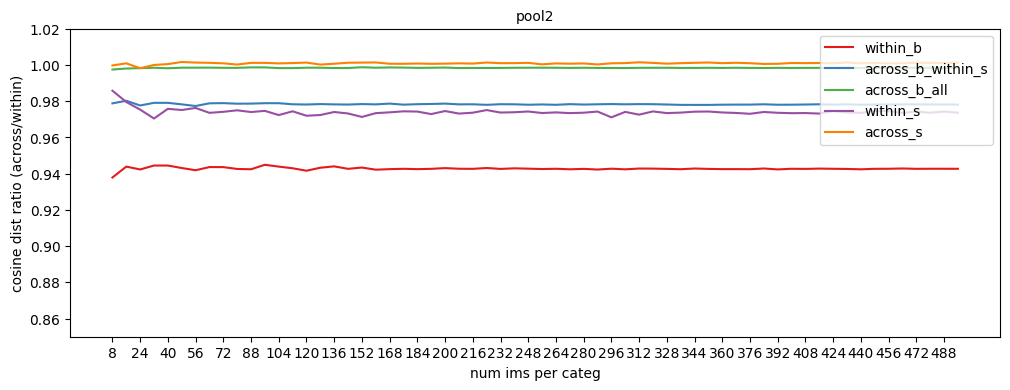

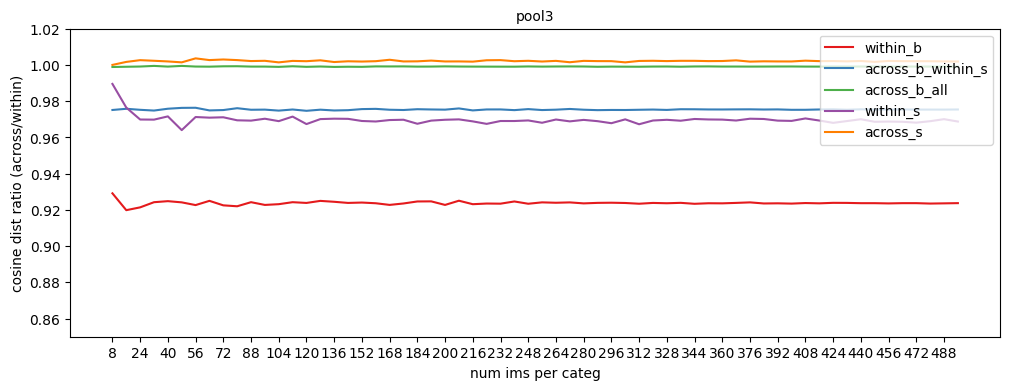

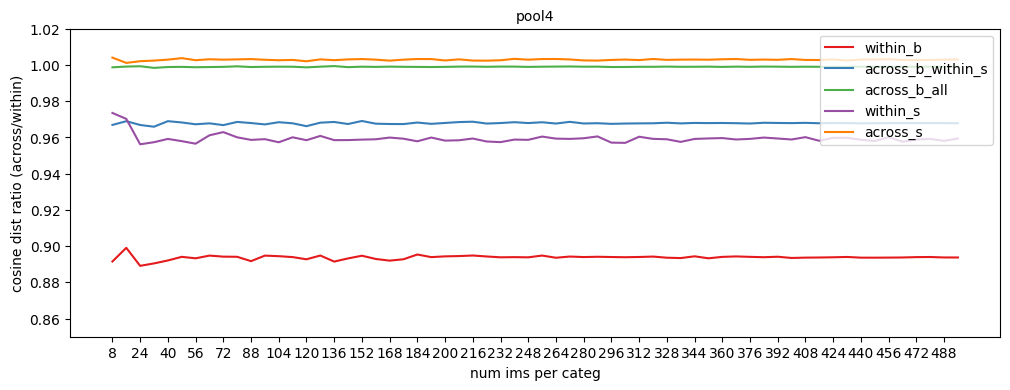

In [11]:
for li in range(n_layers):

    plot_utils.set_all_font_sizes(10)

    colors = cm.Set1(np.linspace(0,1,9))[0:5,:]

    plt.figure(figsize=(12,4))

    ax = plt.subplot(1,1,1)
        # lh = []

    names = d.keys()
    
    for cc, name in enumerate(names):
        
        vals = np.mean(d[name][:,li,:], axis=0)
    
        h = plt.plot(np.arange(n_v), vals,\
                 '-',color=colors[cc,:])

        # lh.append(h[0])

    tick_inds_plot = np.arange(0, n_v, 2)
    plt.xticks(tick_inds_plot, n_ims_vals[tick_inds_plot], rotation=0)

        
    plt.xlabel('num ims per categ')

    # plt.axhline(0, color=[0.8, 0.8, 0.8], linestyle='--')

    # ax.legend(lh, np.repeat(cue_level_vals,2), loc='lower right')
    ax.legend(names, loc='upper right')

    plt.ylabel('cosine dist ratio (across/within)')

    plt.title('%s'%layer_names[li])
    plt.ylim([0.85, 1.02])



#### average across all the basic-level categs in each superordinate category

In [14]:
within_b_each_supcat = np.array([np.mean(within_b[super_inds_long==si,:], axis=0) \
                                for si in range(n_super)])
across_b_within_s_each_supcat = np.array([np.mean(across_b_within_s[super_inds_long==si,:], axis=0) \
                                for si in range(n_super)])
across_b_all_each_supcat = np.array([np.mean(across_b_all[super_inds_long==si,:], axis=0) \
                                for si in range(n_super)])


basic_sep_each_supcat = np.array([np.mean(basic_sep[super_inds_long==si,:], axis=0) \
                                   for si in range(n_super)])

basic_sep_all_each_supcat = np.array([np.mean(basic_sep_all[super_inds_long==si,:], axis=0) \
                                   for si in range(n_super)])

#### plot average separability of each type

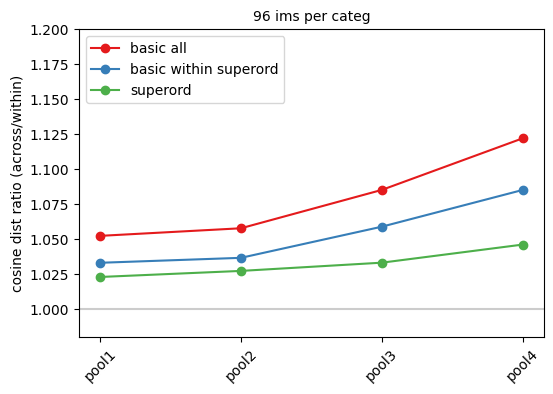

In [10]:
for ni in [11]:

    plot_utils.set_all_font_sizes(10)

    xjitters =np.linspace(-0.05, 0.05, 3)

    cue_level_colors = cm.Set1(np.linspace(0,1,9))[0:3,:]

    point_types = ['o','x']
    markersize = 4;


    plt.figure(figsize=(6,4))

    ax = plt.subplot(1,1,1)
        # lh = []

    vals1 = np.mean(basic_sep_all[:,:,ni], axis=0)
    vals2 = np.mean(basic_sep[:,:,ni], axis=0)
    vals3 = np.mean(super_sep_each_supcat[:,:,ni], axis=0)
    levels = ['basic all','basic within superord','superord']

    for cc, vals in enumerate([vals1, vals2, vals3]):

        h = plt.plot(np.arange(n_layers), vals,\
                 'o-',color=cue_level_colors[cc,:])

        # lh.append(h[0])

        plt.xticks(np.arange(n_layers), layer_names,rotation=45)


    plt.axhline(1.0, color=[0.8, 0.8, 0.8], linestyle='-')

    # ax.legend(lh, np.repeat(cue_level_vals,2), loc='lower right')
    ax.legend(levels, loc='upper left')

    plt.ylabel('cosine dist ratio (across/within)')

    plt.title('%d ims per categ'%n_ims_vals[ni])
    plt.ylim([0.98, 1.20])



Text(0.5, 1.0, '96 ims per categ')

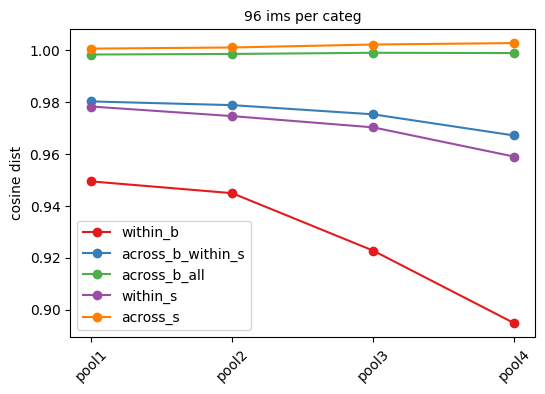

In [18]:
colors = cm.Set1(np.linspace(0,1,9))[0:5,:]

ni = 11

plot_utils.set_all_font_sizes(10)

xjitters =np.linspace(-0.05, 0.05, 3)

point_types = ['o','x']
markersize = 4;


plt.figure(figsize=(6,4))

ax = plt.subplot(1,1,1)
    # lh = []

names = list(d.keys())

for nn, name in enumerate(names):

    vals = np.mean(d[name][:,:,ni], axis=0)
    
    h = plt.plot(np.arange(n_layers), vals,\
             'o-',color=colors[nn,:])

    # lh.append(h[0])

    plt.xticks(np.arange(n_layers), layer_names,rotation=45)


# plt.axhline(0, color=[0.8, 0.8, 0.8], linestyle='--')

# ax.legend(lh, np.repeat(cue_level_vals,2), loc='lower right')
ax.legend(names, loc='lower left')

plt.ylabel('cosine dist')

plt.title('%d ims per categ'%n_ims_vals[ni])
# plt.ylim([1.0, 1.04])


In [19]:
basic_sep.shape

(64, 4, 62)

(0.98, 1.2)

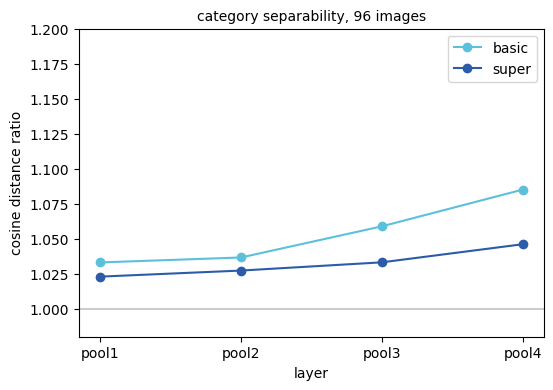

In [11]:
level_colors = np.array([[93,192,219], [44,92,168]])/255
level_names = ['basic','super']

ni = 11;

lh = []

plt.figure(figsize=(6,4))
ax = plt.subplot(1,1,1)
    
for cc, vals in enumerate([basic_sep[:,:,ni], super_sep_each_supcat[:,:,ni]]):

#     for xi in range(vals.shape[0]):

#         plt.plot(vals[xi,:], '-', color=level_colors[cc,:])
        
    h = plt.plot(np.mean(vals, axis=0), 'o-', color=level_colors[cc,:])
    
    lh+=[h[0]]

plt.xticks(np.arange(n_layers), layer_names)

plt.legend(lh, level_names)

plt.axhline(1.0, color=[0.8, 0.8, 0.8])

plt.ylabel('cosine distance ratio')

plt.title('category separability, %d images'%n_ims_vals[ni])

plt.xlabel('layer')

plt.ylim([0.98, 1.20])


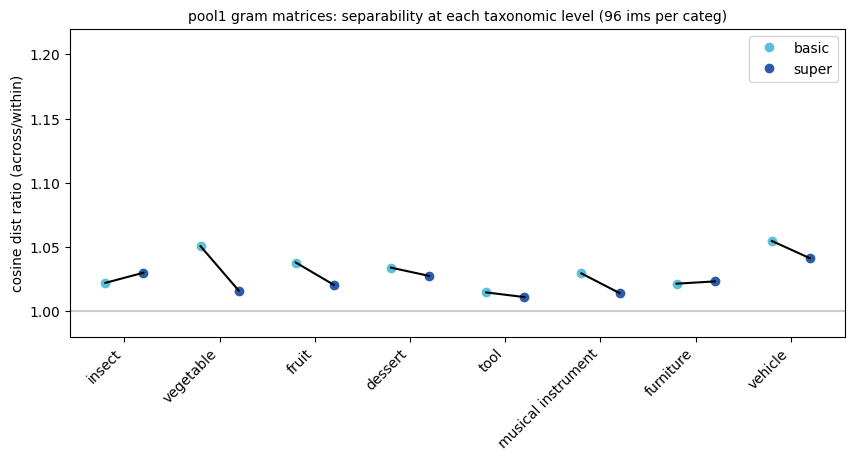

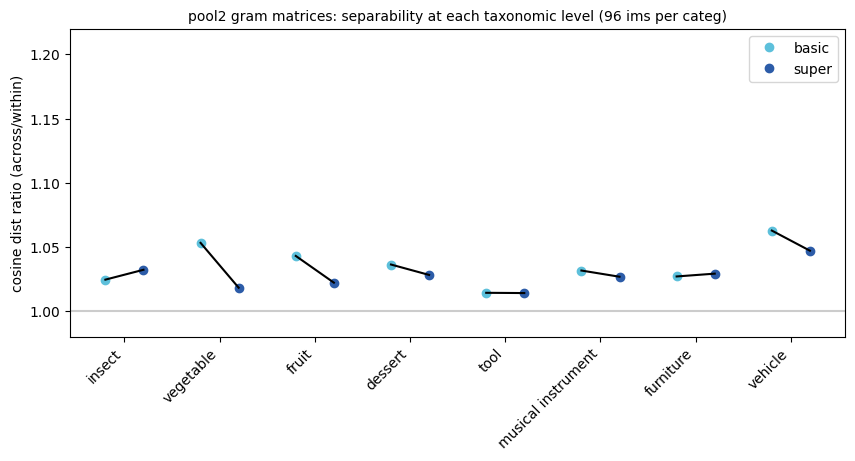

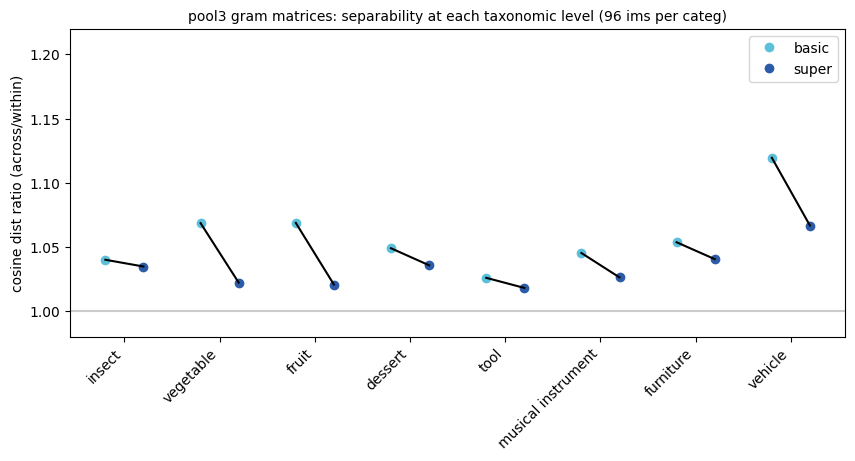

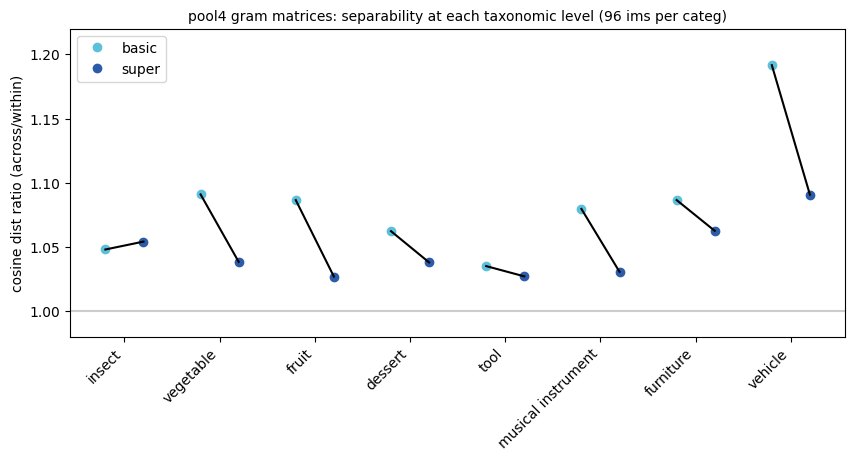

In [16]:
level_colors = np.array([[93,192,219], [44,92,168]])/255
level_names = ['basic','super']

ni = 11;

vals = np.array([basic_sep_each_supcat[:,:,ni], super_sep_each_supcat[:,:,ni]])

xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

for ii in range(n_layers):
    
    
    plt.figure(figsize=(10,4))
    
    lh=[]
    for ca in range(n_super):
    
        for cc in range(2):
            h = plt.plot(ca+xjitters[cc], vals[cc,ca,ii], \
                    'o', color=level_colors[cc,:])
            if ca==0:
                lh+=h
    
        plt.plot(ca+xjitters, vals[:,ca, ii], color='k')
    
    plt.xticks(np.arange(n_super), super_names, rotation=45, ha='right')
    
    plt.axhline(1, color=[0.8, 0.8, 0.8])
    
    plt.title('%s gram matrices: separability at each taxonomic level (%d ims per categ)'%\
              (layer_names[ii], n_ims_vals[ni]))
    
    plt.legend(lh, level_names)
    
    plt.ylabel('cosine dist ratio (across/within)')

    plt.ylim([0.98, 1.22])

#### separate into natural and artificial superord categories

In [10]:
is_natural = np.array([1,1,1,0,0,0,0,0]).astype(bool)
kind_names = ['Artificial','Natural']
n_kinds = len(kind_names)
nat_colors = cm.Greens(np.linspace(0,1,5))[[2,3],:]

NameError: name 'np' is not defined

In [11]:
vals1 = np.mean(basic_sep_all, axis=0)
vals2 = np.mean(basic_sep, axis=0)
vals3 = np.mean(super_sep_each_supcat, axis=0)
levels = ['basic all','basic within superord','superord']

plt.figure(figsize=(12,2))
pi=0

for vals, level in zip([basic_sep_all_each_supcat, \
                        basic_sep_each_supcat, \
                        super_sep_each_supcat], \
                      levels):
        
    pi+=1
    ax = plt.subplot(1,3,pi)
    
    lh = []
    
    for kk in [0,1]:
    
        meanvals = np.mean(vals[is_natural==kk,:], axis=0)
    
        h = plt.plot(np.arange(n_layers), meanvals, color=nat_colors[kk,:])
    
        lh += h
        
    ax.legend(lh, kind_names, loc='upper left');
    plt.xticks(np.arange(n_layers), layer_names, rotation=45);

    if pi==1:
        plt.ylabel('cosine dist ratio (across/within)')
    
    # plt.ylim([1.0, 1.21])
    
    plt.title(level)

NameError: name 'np' is not defined

In [12]:
plt.figure(figsize=(12,2))
pi=0

levels = ['within basic','within superord']
for vals, level in zip([within_b_each_supcat, 
                        within_s], \
                      levels):
        
    pi+=1
    ax = plt.subplot(1,3,pi)
    
    lh = []
    
    for kk in [0,1]:
    
        meanvals = np.mean(vals[is_natural==kk,:], axis=0)
    
        h = plt.plot(np.arange(n_layers), meanvals, color=nat_colors[kk,:])
    
        lh += h
        
    ax.legend(lh, kind_names, loc='lower left');
    plt.xticks(np.arange(n_layers), layer_names, rotation=45);

    if pi==1:
        plt.ylabel('cosine dist')

    # plt.ylim([0.85, 1.0])
    # plt.ylim([1.0, 1.06])
    
    plt.title(level)

NameError: name 'plt' is not defined

In [13]:
plt.figure(figsize=(12,2))
pi=0

levels = ['across all basic','across basic within superord', 'across superord']
for vals, level in zip([across_b_all_each_supcat,
                        across_b_within_s_each_supcat,
                        across_s], \
                      levels):
        
    pi+=1
    ax = plt.subplot(1,3,pi)
   
    lh = []
    
    for kk in [0,1]:
    
        meanvals = np.mean(vals[is_natural==kk,:], axis=0)
    
        h = plt.plot(np.arange(n_layers), meanvals, color=nat_colors[kk,:])
    
        lh += h
        
    ax.legend(lh, kind_names, loc='upper left');
    plt.xticks(np.arange(n_layers), layer_names, rotation=45);

    if pi==1:
        plt.ylabel('cosine dist')

    # plt.ylim([0.98, 1.005])
    # plt.ylim([1.0, 1.06])
    
    plt.title(level)

NameError: name 'plt' is not defined

In [14]:
vals = np.array([within_b_each_supcat[:,:,ni], within_s[:,:,ni]])
xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

for ii in range(n_layers):

    
    plt.figure(figsize=(10,4))
    
    lh=[]
    for ca in range(n_super):
    
        for cc in range(2):
            h = plt.plot(ca+xjitters[cc], vals[cc,ca,ii], \
                    'o', color=cue_level_colors[cc,:])
            if ca==0:
                lh+=h
    
        plt.plot(ca+xjitters, vals[:,ca, ii], color='k')
    
    plt.xticks(np.arange(n_super), super_names, rotation=45, ha='right')
    
    # plt.axhline(1, color=[0.8, 0.8, 0.8])
    
    plt.legend(lh, ['basic','superord'])
    
    plt.title('%s gram matrices: within-category distances at each taxonomic level'%layer_names[ii])


NameError: name 'np' is not defined

In [15]:
vals = np.array([across_b_within_s_each_supcat[:,:,ni], across_s[:,:,ni]])

xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

for ii in range(n_layers):
    
    plt.figure(figsize=(10,4))
    
    lh=[]
    for ca in range(n_super):
    
        for cc in range(2):
            h = plt.plot(ca+xjitters[cc], vals[cc,ca,ii], \
                    'o', color=cue_level_colors[cc,:])
            if ca==0:
                lh+=h
    
        plt.plot(ca+xjitters, vals[:,ca, ii], color='k')
    
    plt.xticks(np.arange(n_super), super_names, rotation=45, ha='right')
    
    # plt.axhline(1, color=[0.8, 0.8, 0.8])
    
    
    plt.legend(lh, ['basic','superord'])
    
    plt.title('%s gram matrices: across-category distances at each taxonomic level'%layer_names[ii])


NameError: name 'np' is not defined